In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [45]:
#Create functions.

#Function that creates an 'observation' of the different light curve models by taking the magnitudes 
#corresponding to 24 hour cadence starting from 0.5 days.
def make_lightcurve(t, mod):
    mag = np.zeros(len(t)) 
    for ind,i in enumerate(t):
        a = np.interp(i, model[mod][:,0], model[mod][:,1])
        mag[ind] = a
    return(mag)

#Function that scales these magnitudes with distance so that they are within a range of the expected 30% error in
#the distance parameter from the GW source.
def make_scale_model(mag, rand_dist_range):
    mag_scale=[]
    for i in range(len(rand_dist_range)):
        obs = mag + 5*np.log10((rand_dist_range[i])/(dist_all_models)) #this comes from m-M = 5log(d) - 5
        mag_scale.append(obs)
    return(mag_scale)

#Function that introduces an error of ±0.25 onto the magnitudes that would come from the optical telescope.
def introduce_telescope_err(mag_scale):
    corrected_mags = []
    rand_err = np.random.uniform(-0.25, 0.25, len(mag_scale[0]))
    for mags in mag_scale:
        corrected_mags.append(mags + rand_err) #adds same 14 errors to the 14 magnitudes of all the scaled models.
    return(corrected_mags)

# combine limiting mag with above if you want
#def limiting_mag(mags): 
#    for i in range(0,len(mags)):
#        ind = np.where(mags[i] > cutoff_mag)[0]
#        mags[i][a] = -1
#    return(mags)
        
    #Creating the cutoff magnitude for the all the models.
    #corrected_mags=[]    
    #for j in range(len(corrected_mags)):
    #    corrected_mags[j][corrected_mags[j] > cutoff_mag] = -1 #if the value of the magnitude in a model is greater
                                                               #than 21 (cutoff) then set that element = -1.
        #num = np.where(corrected_mags[j]==-1) #finds all elements in corrected mags where GOTO cannot observe them.
        #if len(num[0]) > 10: #GOTO has to observe at least 4 points out of 14 for the model to be observed. 
    
    #ERROR WITH CUTOFF MAGNITUDE, SETTING MAGNITUDES TO -1 DESTROYS THE MATCHING FURTHER ON.
    
    #ALSO UNSURE WHAT TO PUT IN 'IF' STATEMENT, COULDN'T REMEMBER WHAT TO INCLUDE INSTEAD OF THE STRING STATEMENT. 
    #DID I NEED TO SET CHI VALUE TO -1?
    
    #return(corrected_mags)

#Function to create a chi squared distribution.
def make_chi_squared(mag_err, mag, cutoff_mag):
    all_chi2 = []
    for mags in mag_err:
        num = np.where(mags > cutoff_mag)[0]
            if len(num) > 10:
                chi2 = 10000
            else:
                # remove -1 elements (so if there are 6 elements in 12 that are -1, make the array length 6)
                chi2 = np.sum(np.square(mags - mag)/mag)
        all_chi2.append(chi2)
    return(all_chi2)

#Function to return a dictionary with the minimmum chi value and the model related to this minimum chi value.
#This is currently where the error is.
def return_best_model(dictionary):
    min_chi2_models = np.ones(len(dictionary)) #creates an array of ones with the length of the dict.
    for i in range(0,len(dictionary)):
        min_chi2_models[i] = min(dictionary[str(i)]) #appends values of dictionary (in string form) to ones array.
    val = min_chi2_models.min() #finds the minimum chisquared value in the model.
    ind = min_chi2_models.argmin() #finds the model where this lowest value lies.
    return(val, ind)

In [46]:
#Load in models.

lc = np.load('light_curves.npz')
m0 = lc['two']
m1 = lc['two_r']
m2 = lc['two_b']
m3 = lc['three']
m4 = lc['three_b']
m5 = lc['KW']
m6 = lc['BR']
m7 = lc['GW']

#Define parameters.

N = 100 #number of kn models in Universe. Currently reduced at the moment whilst fixing errors

model = [m0, m1 ,m2 ,m3 ,m4 ,m5 ,m6 ,m7] #array of all the kn models.
time = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5] #cadence of the observations in days.

dist = np.random.uniform(40,200,N) #Mpc #creates random distance between 40-200 Mpc (range we expect to detect KN).
dist_all_models = 40 #Mpc #reference distance when scaling the magnitudes.
low_dist_err = 0.7 #min distance from the 30% error range.
high_dist_err = 1.3 #max distance from the 30% error range.

cutoff_mag = 21 #GOTO will not be able to observe anything beyond this magnitude.

In [5]:
#Simulating N kilonova models in the universe.

#List of empty arrays used to append values in the loop.
array_kns = []
all_kn_distance = []
model_distance = []
min_chi2 = []
best_model = []
ind_chi2 = []
dist_ind_value = []

for j in range(N):
    
    #Create kn in universe.
    x = np.random.randint(0, 8) #chooses a random model out of the 8.
    gen_kn = make_lightcurve(time, x) #universe creates 'observation' of model with magnitudes taken at cadences.
    kn = make_scale_model(gen_kn, [dist[j]]) #places this observation model at a random distance.
    
    #Record model of kn chosen to store in dictionary later.
    array_kns.append(x)
    
    #Work out step of model over distance to give a range between min and max 30% error range.
    dist_range = np.arange(np.floor(low_dist_err*dist[j]), np.ceil(high_dist_err*dist[j]), 1)
    
    #Use functions defined and loop them over all models.
    chisquare_models = []
    for i in range(len(model)):
        magnitude = make_lightcurve(time, i) #inserting model number from 0-7 (models 1-8) and times for cadenece.
        scale = make_scale_model(magnitude, dist_range) #inserting the returned 'mag' from previous magnitude 
                                                        #function and the distance range to scale models over.
        error = introduce_telescope_err(scale) #inserting the scaled magnitudes from the scale function.
        
        #mags = limiting_mag(error)
             
        chisquare = make_chi_squared(error, kn, cutoff_mag) #inserting the corrected magnitudes and the magnitudes from
                                                #the original kn model.
        chisquare_models.append(chisquare) #appending the chisquare values for each of the 8 models

    #Save chisquared data for each model in a dictionary.
    chi_dict = {'0':chisquare_models[0], '1':chisquare_models[1], '2':chisquare_models[2], '3':chisquare_models[3], '4':chisquare_models[4], '5':chisquare_models[5], '6':chisquare_models[6], '7':chisquare_models[7]}
    
    #Using return best model function to find the min chi and best model fit for all the models over every iteration.
    return_best_model(chi_dict)
    # right now you do not distinguish what is considered a good chi2 - need a limit
    lowest_chi = return_best_model(chi_dict)[0]
    related_model = return_best_model(chi_dict)[1]
    min_chi2.append(lowest_chi)
    best_model.append(related_model)
    
    #Finding the index of the minimum chi value to find out where the distance of the model is.
    chi_index_min = np.argmin(chisquare_models[int(related_model)]) #finds index of min chisquare value in models.
    ind_chi2.append(chi_index_min)
    dist_range_index = dist_range[int(chi_index_min)] #puts index of min chi into distance to get a value.
    dist_ind_value.append(dist_range_index)
    
    #Looping over dist_all_models N times for kn_info dict.
    all_kn_distance.append(int(dist[j]))

In [6]:
#Save KN, best fit model, min chi2 value, model distance (use indexing to find lowest) and KN distance)

kn_info = {'KN model':array_kns, 'Best fit model':best_model, 'Minimum Chi2':min_chi2, 'Model distance':dist_ind_value, 'KN distance':all_kn_distance}
print(kn_info)

{'KN model': [5, 7, 1, 2, 2, 3, 5, 1, 5, 7, 0, 7, 2, 7, 3, 0, 3, 6, 3, 3, 7, 7, 6, 6, 4, 0, 7, 7, 0, 7, 7, 7, 6, 3, 6, 0, 5, 1, 2, 1, 5, 6, 1, 2, 7, 1, 2, 7, 0, 6, 2, 7, 2, 5, 1, 2, 1, 6, 7, 7, 2, 1, 7, 1, 1, 7, 5, 0, 1, 0, 2, 6, 6, 0, 4, 2, 7, 3, 7, 7, 3, 4, 6, 7, 3, 6, 5, 7, 5, 2, 1, 3, 1, 7, 6, 4, 4, 3, 1, 2], 'Best fit model': [5, 7, 1, 2, 2, 3, 5, 1, 5, 7, 0, 7, 2, 7, 3, 0, 3, 6, 3, 3, 7, 7, 6, 6, 4, 0, 7, 7, 0, 7, 7, 7, 6, 3, 6, 0, 5, 1, 2, 1, 5, 6, 1, 2, 7, 1, 2, 7, 0, 6, 2, 7, 2, 5, 1, 2, 1, 6, 7, 7, 2, 1, 7, 1, 1, 7, 5, 0, 1, 0, 2, 6, 6, 0, 4, 2, 7, 3, 7, 7, 3, 4, 6, 7, 3, 6, 5, 7, 5, 2, 1, 3, 1, 7, 6, 4, 4, 3, 1, 2], 'Minimum Chi2': [0.013070963491573155, 0.0079481533385588037, 0.014241014221069373, 0.014118102492528123, 0.0080190334859509462, 0.014157668930607974, 0.010184751330150217, 0.015971193226974129, 0.0054633422600435418, 0.015495852077091232, 0.010385321528519996, 0.010962657931124218, 0.0046928188222509727, 0.010208847087757987, 0.0097608584261511654, 0.01274231464

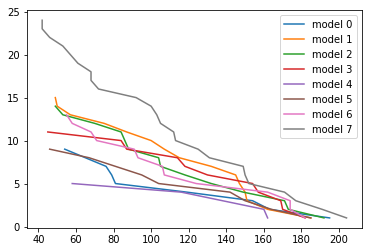

In [33]:
array_kns = np.asarray(array_kns)
best_model = np.asarray(best_model)

match = 1
non_match = 0

plt.figure()

for i in range(0,len(model)):
    label = 'model %s' % i
    
    kn_ind = np.where(array_kns==i)[0]
    best_ind = best_model[kn_ind]
 
    match_dist = np.zeros(len(kn_ind))
    cumulative = np.zeros(len(kn_ind))

    for j in range(0,len(kn_ind)):
        match_dist[j] = kn_info['Model distance'][kn_ind[j]]
        if best_ind[j] == i:
            cumulative[j] = match
        else:
            cumulative[j] = non_match

    cumsum = np.cumsum(cumulative)[::-1]
    dist = np.sort(match_dist)

    plt.plot(dist, cumsum, label=label)
    plt.legend()

plt.show()

95.0
[array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), array([2, 2, 2, 2, 

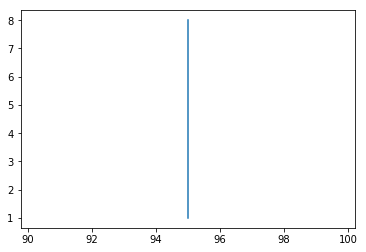

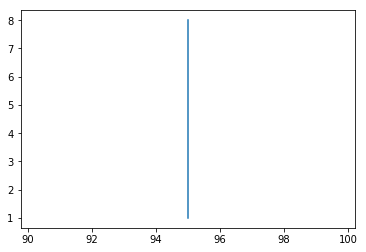

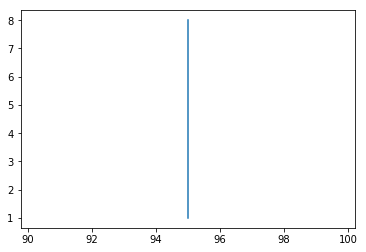

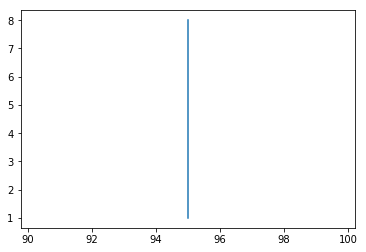

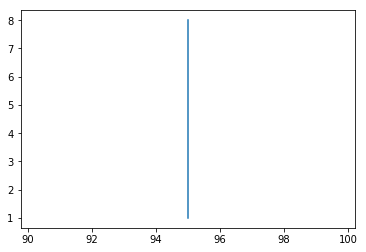

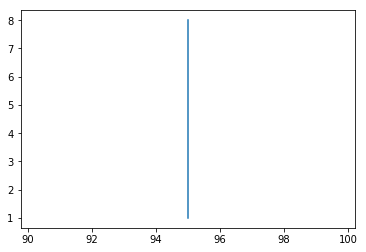

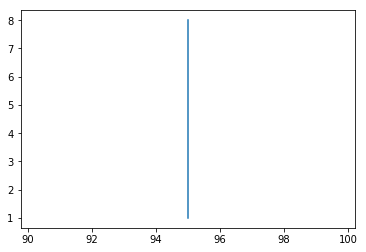

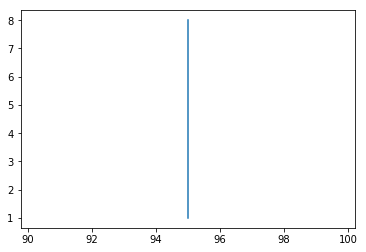

In [8]:
#Creating the efficiency curve.

#Setting empty arrays and the conditions for a match/non-match.
best_val = []
cumulative = []
match_dist = []
match = 1
non_match = 0

#Turning arrays into numpy arrays.
array_kns = np.asarray(array_kns)
best_model = np.asarray(best_model)

#Loop iterates through model numbers 0-7 and then nested loop iterates through model numbers 0-7.
for i in range(len(model)):
    for j in range(len(model)):
        kn_ind = np.where(array_kns==i) #finds the indicies where the kn model is model i (i.e. 0 and then 1, ect.)
        best_ind = best_model[kn_ind] #puts these indicies into the best fit model to find whether the
                                      #theoretical and best fit models are the same at the same index point.
        best_val.append(best_ind)
        if best_val[i][j] == i: #if the value of the best fit model is the same as the theoretical model
                                #(i.e. [0][0-7] equals 0) then we append it as a match and take the distance.
            match_dist.append(dist_ind_value[best_val[i][j]]) #BROKEN HERE
            cumulative.append(match)
        else: #if the value of best fit model is the not same as the theoretical model (i.e. [0][0-7] equals 1-7)
              #then we append it as a non-match and take the distance.
            match_dist.append(dist_ind_value[best_val[i][j]]) #BROKEN HERE
            cumulative.append(non_match)
    cumsum = np.cumsum(cumulative)
    #plotting figures in loop so it will plot 8 different efficiency curves for the 8 different models.
    plt.figure()
    plt.plot(match_dist, cumsum)
    name = 'eff_curve_model_%s.png' % i
    plt.savefig(name)
    
#DISTANCE IS CURRENTLY BROKEN AS GIVES THE SAME VALUE WHEN TRYING TO CALL UPON THE INDEX OF THE MODEL DISTANCE.
    
#NEED TO PLOT ALL EFFICIENCY CURVES ON SAME FIGURE.
    
print(dist_ind_value[best_val[0][0]])
print(best_val)
print(cumsum)

In [ ]:
plt.figure(figsize=(9,7))
plt.plot(dist_range, chi_dict['0'], color='black', label='Two Component Model')
plt.plot(dist_range, chi_dict['1'], color='red', label='Red Two Component Model')
plt.plot(dist_range, chi_dict['2'], color='blue', label='Blue Two Component Model')
plt.plot(dist_range, chi_dict['3'], color='black', linestyle='dashed', label='Three Component Model')
plt.plot(dist_range, chi_dict['4'], color='blue', linestyle='dashed', label='Blue Three Component Model')
plt.plot(dist_range, chi_dict['5'], color='green', label='Kawaguchi et al.')
plt.plot(dist_range, chi_dict['6'], color='orange', label='Barbieri et al.')
plt.plot(dist_range, chi_dict['7'], color='fuchsia', label='GW170817')
plt.xlabel('Distance (Mpc)')
plt.ylabel('$\chi^{2}$')
plt.grid()
plt.legend()
plt.savefig('chi_ehanced.png')

In [ ]:
#Simulating where GOTO is in the world

#ra = np.random.normal(np.pi, np.pi/4, 1000000)
#dec = np.random.normal(0, np.pi/8, 1000000)

#goto_loc = 